/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_70366/2925946944.py:35: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


About exogenous variables:
grid is [0.25 1.25].
Transition matrix is [[0.8 0.2]
 [0.2 0.8]].
Error at iteration 25 is 0.023640000758869073.
Error at iteration 50 is 0.006865712888389108.
Error at iteration 75 is 0.0030707263788362082.
Error at iteration 100 is 0.0017673442623434843.
Error at iteration 125 is 0.0011676039973096408.
Error at iteration 150 is 0.000840547347407905.
Error at iteration 175 is 0.0006409433292376976.
Error at iteration 200 is 0.0005089909547467686.
Error at iteration 225 is 0.00041645476084750666.
Error at iteration 250 is 0.0003485758331566169.
Error at iteration 275 is 0.0002970037218575916.
Error at iteration 300 is 0.00025670529753607507.
Error at iteration 325 is 0.00022448696727295214.
Error at iteration 350 is 0.0001982347620788083.
Error at iteration 375 is 0.0001764990618796647.
Error at iteration 400 is 0.00015825570206051687.
Error at iteration 425 is 0.0001427624057835919.
Error at iteration 450 is 0.00012946920412404417.
Error at iteration 475 is 

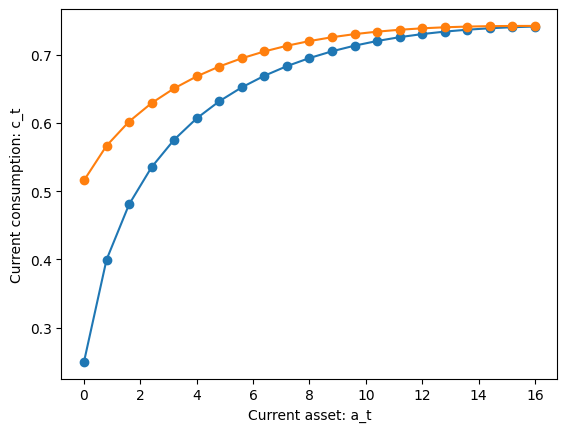

In [1]:
import numpy as np
from quantecon.optimize import brentq
from quantecon.markov import rouwenhorst
from interpolation import interp
from numba import njit
import matplotlib.pyplot as plt
# %matplotlib inline
import pandas as pd


# 解く問題の設定を行う（パラメータ, グリッド, 効用関数や生産関数）
# モデルを変更する場合にはここを修正
class Setting:

    def __init__(self,
                R=1.01,                          # 粗実質利子率
                beta=0.99,                          # 割引因子
                gamma=1,                          # 相対的リスク回避度(異時点間の代替弾力性の逆数)
                b=0,                             # 内生的な状態変数の最小値, 借入制約
                a_max=16,                        # 内生的な状態変数の最大値
                na=21,                           # 内生的な状態変数のグリッド数
                mu=0,                            # 外生変数のAR(1)過程の定数項
                rho=0.6,                        # 外生変数のAR(1)過程の慣性
                sigma=0.4,                       # 外生変数のAR(1)過程のショック項の標準偏差
                nz = 11,                         # 外生変数のグリッド数
                lambdaPF = 1):                 # 政策関数の更新度

        # パラメータを設定する
        self.R = R
        self.beta = beta
        self.b = b
        self.gamma = gamma

        # 外生変数の遷移確率とグリッドを設定する
        mc = rouwenhorst(nz, rho, sigma, mu)
        self.Pz = mc.P
        self.z_grid = mc.state_values

        # 内生的な状態変数のグリッドを設定する
        a_grid = np.linspace(-b, a_max, na)
        self.a_grid = a_grid

        # 政策関数の更新度を設定する
        self.lambdaPF = lambdaPF


        # CRRA型効用関数と限界効用を定義する
        if gamma == 1:
            utility = np.log
            mutility = njit(lambda x: 1 / x)
        else:
            utility = njit(lambda x: x**(1-gamma) / (1 - gamma))
            mutility = njit(lambda x: x**(-gamma))
        self.utility = utility
        self.mutility = mutility

		    # 政策関数の初期値を定義する
        z_grid = self.z_grid
        hfun_old = np.empty((len(a_grid), len(z_grid)))
        for i_a, a in enumerate(a_grid):
            for i_z, z in enumerate(z_grid):
                c_max = 0.5* (R * a + z + b)
                hfun_old[i_a, i_z] = c_max
        self.hfun_old = hfun_old


# 特定のアルゴリズムを実行して政策関数を更新する関数を出力する
# FOCを変更する場合やアルゴリズムを変更する場合はここを修正

# 今期の状態変数について繰り返し記号はi, 来期の状態変数について繰り返し記号はj

def TimeIteration(hp): # hpはSettingクラスからつくられるインスタンス

    # インスタンスからローカル変数を定義する
    R, beta, b, mutility = hp.R, hp.beta, hp.b, hp.mutility
    a_grid, z_grid, Pz = hp.a_grid, hp.z_grid, hp.Pz

    @njit
    def FOCs(c, a, z, i_z, hfun):

        # 制約式から次期の内生的な状態変数を計算する
        aprime = R * a + z - c

        expectation = 0
        for j_z in range(len(z_grid)):
            # 政策関数の候補を補間して次期の制御変数を計算する
            cprime = interp(a_grid, hfun[:, j_z], aprime)

            # オイラー方程式の右辺を計算する
            expectation += mutility(cprime) * Pz[i_z, j_z]

        rhs = max(R * beta * expectation, mutility(R * a + z + b))

        FOC_diff = mutility(c) - rhs

        return FOC_diff


    @njit
    def UpdatePF(h_old):

        h_new = np.empty_like(h_old)
        for i_a in range(len(a_grid)):
            a = a_grid[i_a]
            for i_z in range(len(z_grid)):
                z = z_grid[i_z]
                c_star = brentq(FOCs, 1e-8, R * a + z + b, args=(a, z, i_z, h_old)).root
                h_new[i_a, i_z] = c_star

        return h_new

    return UpdatePF





# メイン関数：特定のアルゴリズムでiterationを行い、問題を解く関数
# 基本的には変更する必要がない

def SolveProblem(hp,               # Settingクラスからつくられるインスタンス
                Algorithm,         # アルゴリズムを指定
                tol=1e-4,          # 許容繰り返し誤差
                max_iter=10000,     # iteration回数の最大値
                verbose=True,      # 進捗を表示するかどうか
                print_skip=25):    # 進捗を何回ごとに表示するか


    # インスタンスからローカル変数を定義する
    R, beta, b, mutility = hp.R, hp.beta, hp.b, hp.mutility
    a_grid, z_grid, Pz = hp.a_grid, hp.z_grid, hp.Pz
    lambdaPF = hp.lambdaPF
    hfun_old = hp.hfun_old

    # チェックのために外生変数のグリッドと遷移確率を表示する
    print(f"About exogenous variables:")
    print(f"grid is {z_grid}.")
    print(f"Transition matrix is {Pz}.")



    # 政策関数を更新する関数を取得する
    UpdatePF = Algorithm(hp)

    # iterationを行い、問題を解く
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:

        # 政策関数を更新する
        hfun_new_tilde = UpdatePF(hfun_old)

        # 古い政策関数と加重平均する
        hfun_new = lambdaPF*hfun_new_tilde + (1-lambdaPF)*hfun_old

        error = np.max(np.abs(hfun_new-hfun_old))
        i += 1
        if verbose and i % print_skip == 0:      # 進捗をprint_skip回ごとに表示する
            print(f"Error at iteration {i} is {error}.")
        hfun_old = hfun_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return hfun_new



hp = Setting(mu = 0.3, nz = 2)
hfun_c = SolveProblem(hp,TimeIteration)



# 消費の政策関数をプロット
df = pd.DataFrame({
    'x_axis': hp.a_grid,
    'y_axis': hfun_c[:,0]})
df2 = pd.DataFrame({
    'x_axis': hp.a_grid,
    'y_axis': hfun_c[:,1]})
# plot
plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o')
plt.plot('x_axis', 'y_axis', data=df2, linestyle='-', marker='o')
plt.xlabel('Current asset: a_t')
plt.ylabel('Current consumption: c_t')
# plt.legend([""])
plt.show()

In [2]:
print(hfun_c)

[[0.25       0.51572483]
 [0.39957225 0.56641839]
 [0.48056488 0.60190878]
 [0.53512963 0.62896898]
 [0.57537197 0.65049536]
 [0.60658856 0.66803102]
 [0.63158144 0.68250868]
 [0.65200723 0.6945417 ]
 [0.66892181 0.70455998]
 [0.6830372  0.71288141]
 [0.69485644 0.71975255]
 [0.70474999 0.72537305]
 [0.71300167 0.72991086]
 [0.71983741 0.73351172]
 [0.72544377 0.73630502]
 [0.72998004 0.7384074 ]
 [0.73358608 0.73992464]
 [0.73638728 0.74095267]
 [0.73849756 0.74157797]
 [0.740021   0.74187772]
 [0.74105262 0.74191984]]


In [3]:
trans_prob_pf = np.array([[[1,2,3], [4,5,6]],
                          [[7,8,9], [10,11,12]],
                          [[13,14,15], [16,17,18]]])

In [4]:
trans_prob_pf[:,:,0]

array([[ 1,  4],
       [ 7, 10],
       [13, 16]])